In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_snippets torch_summary --quiet
import itertools
from PIL import Image
from torch_snippets import *
from torchvision import transforms
from torchvision.utils import make_grid
from torchsummary import summary
import torch
from torch.utils.data import Dataset, DataLoader
import os
from glob import glob
from random import randint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.1 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks=6):  # Reduced number of residual blocks
        super(GeneratorResNet, self).__init__()
        out_features = 32  # Reduced feature maps
        channels = 3
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
        self.apply(weights_init_normal)

    def forward(self, x):
        return self.model(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self.apply(weights_init_normal)

    def forward(self, img):
        return self.model(img)

In [ ]:
IMAGE_SIZE = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
G_AB = GeneratorResNet().to(device)
G_BA = GeneratorResNet().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

In [ ]:
model_save_path_G_AB = '/content/drive/MyDrive/CycleGan/G_AB.pth'
model_save_path_G_BA = '/content/drive/MyDrive/CycleGan/G_BA.pth'
model_save_path_D_A = '/content/drive/MyDrive/CycleGan/D_A.pth'
model_save_path_D_B = '/content/drive/MyDrive/CycleGan/D_B.pth'

In [ ]:
G_AB.load_state_dict(torch.load(model_save_path_G_AB))
G_BA.load_state_dict(torch.load(model_save_path_G_BA))
D_A.load_state_dict(torch.load(model_save_path_D_A))
D_B.load_state_dict(torch.load(model_save_path_D_B))

<ipython-input-15-7014589cc8af>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_AB.load_state_dict(torch.load(model_save_path_G_AB))
<ipython-input-15-7014589cc8af>:2: Fu

<All keys matched successfully>

In [ ]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
optimizer_G.load_state_dict(torch.load('/content/drive/MyDrive/CycleGan/optimizer_G.pth'))
optimizer_D_A.load_state_dict(torch.load('/content/drive/MyDrive/CycleGan/optimizer_D_A.pth'))
optimizer_D_B.load_state_dict(torch.load('/content/drive/MyDrive/CycleGan/optimizer_D_B.pth'))

<ipython-input-17-dc9334efa65e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer_G.load_state_dict(torch.load('/content/drive/MyDrive/CycleGan/optimizer_G.pth'))
<

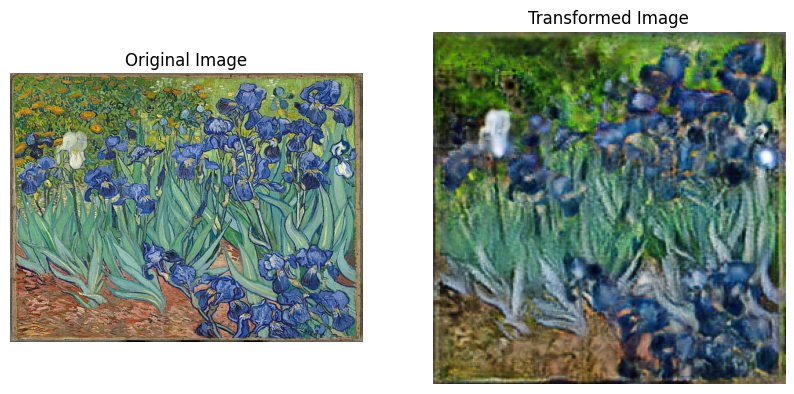

Transformed image saved at transformed_image.jpg


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load your CycleGAN generators (assuming G_AB and G_BA are your generators)
G_AB.eval()

# Load the image
image_path ='/content/drive/MyDrive/CycleGan/00021.jpg'
image = Image.open(image_path).convert('RGB')

# Define the transformation (resize and normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Preprocess the image
input_image = transform(image).unsqueeze(0).to(device)
# Apply the CycleGAN generator
with torch.no_grad():
    fake_image =G_AB(input_image)
    fake_image = fake_image.cpu()  # Move back to CPU

# Post-process the output image
fake_image = fake_image.squeeze(0)
fake_image = (fake_image * 0.5 + 0.5)
fake_image = fake_image.permute(1, 2, 0)
fake_image = (fake_image * 255).byte().numpy()

# Save the transformed image
output_image_path ='transformed_image.jpg'
Image.fromarray(fake_image).save(output_image_path)

# Display the original and transformed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(fake_image)
plt.axis('off')

plt.show()

print(f'Transformed image saved at {output_image_path}')

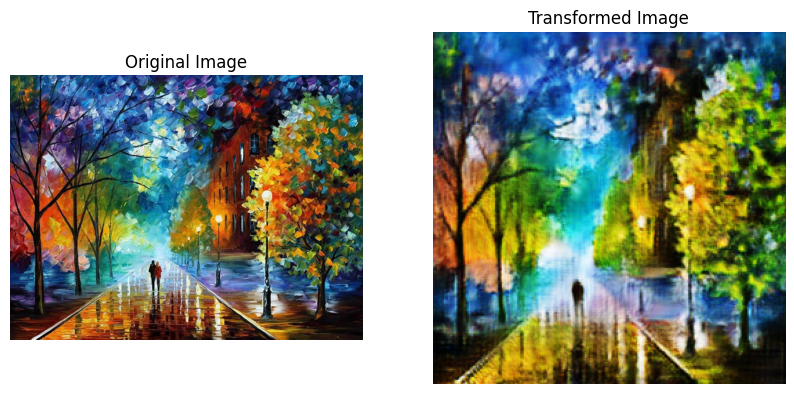

Transformed image saved at traditional_paintings_02-transformed.jpg


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load your CycleGAN generators (assuming G_AB and G_BA are your generators)
G_AB.eval()

# Load the image
image_path ='/content/drive/MyDrive/CycleGan/traditional_paintings_02.jpg'
image = Image.open(image_path).convert('RGB')

# Define the transformation (resize and normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Preprocess the image
input_image = transform(image).unsqueeze(0).to(device)
# Apply the CycleGAN generator
with torch.no_grad():
    fake_image =G_AB(input_image)
    fake_image = fake_image.cpu()  # Move back to CPU

# Post-process the output image
fake_image = fake_image.squeeze(0)
fake_image = (fake_image * 0.5 + 0.5)
fake_image = fake_image.permute(1, 2, 0)
fake_image = (fake_image * 255).byte().numpy()

# Save the transformed image
output_image_path ='traditional_paintings_02-transformed.jpg'
Image.fromarray(fake_image).save(output_image_path)

# Display the original and transformed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(fake_image)
plt.axis('off')

plt.show()

print(f'Transformed image saved at {output_image_path}')